# Introduksjon 
Denne notebook'en gir en introduksjon til grafer og bredde-først søk. Presentasjonen av algoritmene er inspirert av [Red Blob Games: Introduction to the A* algorithm](https://www.redblobgames.com/pathfinding/a-star/introduction.html)

Oppgavene som hører til dette temaet er oppgitt nederst i denne notebook'en. Oppgavene består i å implementere funksjonene som allerede er definert i fila graph_search.py. 

Søkealgoritmer for grafer er veldig generelle og kan brukes i mange sammenhenger, men i denne introduksjonen skal vi for det meste bruke dem til å finne veier gjennom et 2-dimensjonalt rutenett. Prøv likevel å huske at algoritmene har mange bruksområder utenom dette.

La oss importere noen moduler som skal hjelpe oss på veien (i tilfelle du får feilmeldinger, se kommentarer under):

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import graph_tools as gt  # See graph_tools.py in repository
import graph_search_solution as gs
import graphviz

## Moduler:
- Numpy brukes gjerne i Python når man skal behandle "arrays" av ulike typer. Vi skal representere vårt rutenett som et 2D array.
- Matplotlib brukes for å plotte både grafer og bilder.
- graph_tools er en samling ferdig implementert "helpekode" for å lese og visualisere stoffet vi jobber med.
- graph_search_solution er en ferdig implementasjon av funksjonene som skal implementeres i innlevering 3. Når dere har laget deres egen implementasjon kan dere kjøre denne notebook'en og se hvordan koden deres fungerer på eksemplene under.  
- graphviz for python består egentlig av 2 deler; et generelt program som installeres og en python-modul for interaksjon med programmet. Det er imidertid mulig å installere begge deler med Conda (ikke pip): conda install graphviz  Hvis dette ikke fungerer kan du prøve å følge [instruksjonene for installasjon via pip](https://pypi.org/project/graphviz/).  Hvis du ikke får noe av dette til å fungere: Det er ikke så farlig. Kommenter ut / hopp over kodeceller som bruker graphviz, og gå videre. 

## Importere eksempel-rutenett
Koden i cellene under leser inn ei fil med et eksempel-rutenett og visualiserer den på flere ulike måter. I tekst-form representerer "#" vegger og "." åpne ruter (ganger). Når dette konverteres til en matrise, er veggene representert med 0 og gangene representert med 1. Når man viser matrisen som et bilde, er veggene mørkeblå og gangene gule.

In [2]:
# Read maze text from file and print each line
maze_text = gt.read_maze_text('mazes/maze_10x10.txt')
for line in maze_text: print(line)

##########
#..#...#.#
#.##.#...#
#.#....#.#
#....#...#
#.#..#.###
###.##.#.#
#.#.#....#
#.....#..#
##########


In [3]:
# Convert the maze text to a matrix
grid = gt.maze_text_to_matrix(maze_text)
print(grid)

[[0 0 0 0 0 0 0 0 0 0]
 [0 1 1 0 1 1 1 0 1 0]
 [0 1 0 0 1 0 1 1 1 0]
 [0 1 0 1 1 1 1 0 1 0]
 [0 1 1 1 1 0 1 1 1 0]
 [0 1 0 1 1 0 1 0 0 0]
 [0 0 0 1 0 0 1 0 1 0]
 [0 1 0 1 0 1 1 1 1 0]
 [0 1 1 1 1 1 0 1 1 0]
 [0 0 0 0 0 0 0 0 0 0]]


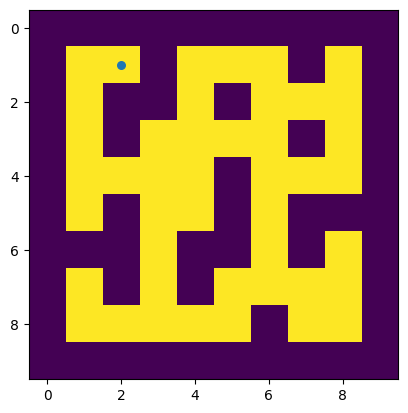

In [4]:
# Show the matrix as an image and add an example start point
plt.imshow(grid)
plt.scatter(x=2,y=1,s=30)  
plt.show()

Legg merke til koordinatsystemet langs kantene av bildet. Koordinatene er heltall, og følger samme system som i matrisenotasjon/bildebehandling - man oppgir først radnummer (fra toppen) og deretter kolonnenummer (fra venstre). For eksempel ligger prikken på bildet i koordinat (1,2), dvs. rad 1 og kolonne 2. Merk at dette tilsvarer rekkefølgen (y,x) og IKKE (x,y), hvis man lar x representere horisontal posisjon og y representere vertikal posisjon. 

# Ulike representasjoner av grafer
## Rutenett
Før vi beskriver selve søkealgoritmene må vi se litt nærmere på hvordan vi kan beskrive rutenettet vårt som en graf. Vi begynner med et veldig lite rutenett for å holde grafen oversiktelig. Vi plotter også et startpunkt og viser hvilke retninger vi kan bevege oss i fra startpunktet.  

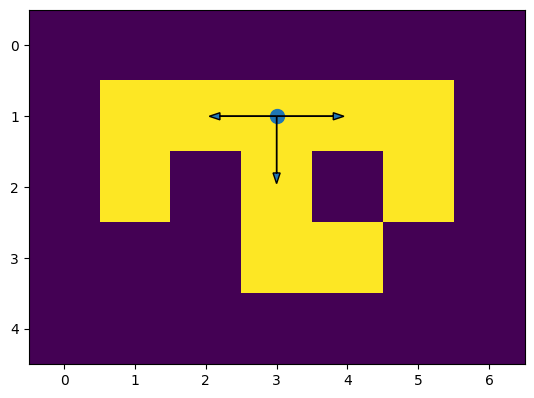

In [5]:
maze_text = gt.read_maze_text('mazes/maze_3way.txt')
_ = plt.imshow(gt.maze_text_to_matrix(maze_text))
_ = plt.scatter(y=1,x=3,s=100)
gt.plot_maze_edges({(1,3):[(1,2),(2,3),(1,4)]})

We kan tenke på hver gule piksel som en "node" i en graf. Hver slik node kan har opp til 4 nabonoder (venstre, høyre, opp, ned). Hvis en node har en nabo, betyr det at vi kan forflytte oss til den. I grafen over kan vi for eksempel forflytte oss fra punktet (1,3) nedover til (2,3). Vi sier at det går en "kant" (dvs. en mulig overgang) mellom nabonodene.

## Adjacency list
I denne presentasjonen, og i oppgavene som dere skal gjøre, vil vi bruke en "dictionary" for å holde oversikt over nodene og kantene i grafen. Hver node er representert med sine koordinater som nøkler, og den tilsvarende verdien er en liste med koordinatene til alle nabo-nodene. Dette er et eksempel på en såkalt "adjacency list". Vi bruker funksjonen parse_maze_text() for å fylle inn en slik liste for grafen. 

In [6]:
graph = gt.maze_text_to_graph(gt.read_maze_text('mazes/maze_3way.txt'))
for node, neighbors in graph.items():
    print(f'{node}: {neighbors}')

(1, 1): [(2, 1), (1, 2)]
(1, 2): [(1, 1), (1, 3)]
(1, 3): [(1, 2), (2, 3), (1, 4)]
(1, 4): [(1, 3), (1, 5)]
(1, 5): [(1, 4), (2, 5)]
(2, 1): [(1, 1)]
(2, 3): [(3, 3), (1, 3)]
(2, 5): [(1, 5)]
(3, 3): [(3, 4), (2, 3)]
(3, 4): [(3, 3)]


Legg merke til at startpunktet i piksel (1,3) har tre naboer, mange av nodene har to naboer, og de tre "blindveiene" har bare en nabo. 

## Ellipser og streker
La oss ta oss tid til å visualisere grafen på en nok en måte, der nodene er vist som ellipser og kantene er vist som streker mellom nodene. Denne måter er antakelig den vanligste måten å vise grafer på, men den blir fort uoversiktelig hvis antallet noder blir mer enn 20-30. 

OBS: Funksjonen dict_to_dot() under bruker Graphviz for å generere visualiseringer av grafer. Hvis du ikke får til å installere graphviz: Kommenter ut / hopp over koden og gå videre. 

In [7]:
def dict_to_dot(adj_dict, directed=False):
    """ Create graphviz graph based on adjancency list (dictionary) 
    
    # Input parameters:
    adj_dict     - Adjacency list as dictionary
                   key = node name
                   value = iterable with neighbor node names
    directed     - Boolean, True for directed graph, False for undirected.
    
    # Returns:
    graph_dot    - Graphviz graph object (Graph or Digraph)
    
    """ 
    
    if directed:
        graph_dot = graphviz.Digraph(strict=True)
    else:
        graph_dot = graphviz.Graph(strict=True)
    
    for from_vertex in adj_dict.keys():
        for to_vertex in adj_dict[from_vertex]:           # Assume dict of iterables
            graph_dot.edge(tail_name = str(from_vertex),
                        head_name = str(to_vertex))
    
    return graph_dot

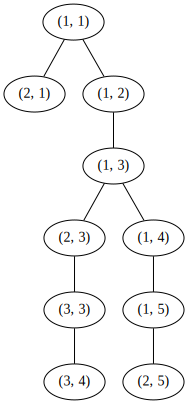

In [8]:
graph_dot = dict_to_dot(graph)
graph_dot

Ta gjerne en liten stopp og sjekk av du skjønner sammenhengen mellom de tre måtene den samme grafen er vist på her; som et bilde med piksler, som en liste med nabonober, og som en tegning med ellipser og streker. 

# Bredde-først traversering
Nå kan vi (omsider!) begynne å beskrive algoritmene for å søke gjennom rutenettene / grafene. Vi begynner med bredde-først _traversering_. Med traversering mener vi at algoritmen skal besøke _alle_ nodene i hele grafen. Vi skal se senere at når vi _søker_ i grafen (leter etter en spesifikk node) trenger vi ikke besøke alle nodene. Men først, altså - traversering. Pseudokoden under beskriver algoritmen som skal brukes (og som dere skal implementere). 

    breadth_first_traverse(graph,start_node):
        let frontier equal a new queue
        let came_from equal a new dict
        
        enqueue start_node to frontier
        set came_from for start_node to None
        
        while frontier is not empty:
            dequeue a node from frontier and let it equal current_node
            for every neighbor of current_node in graph:
                if the neighbor has not been discovered (not yet present in came_from):
                    enqueue the neighbor to frontier
                    update came_from: set neighbor as key and current_node as value
        
        return came_from

I denne koden brukes en kø for å ta vare på alle noder som er "oppdaget" (dvs. de er naboer til en node som man har "besøkt"). Nodene behandles/"besøkes" i samme rekkefølge som de ble lagt inn i køen (first-in-first-out). Datastrukturen came_from har to funksjoner:
    - Den forteller hvilken rekkefølge nodene ble "oppdaget" i. Hvis node B oppdages fra node A, settes came_from[B] = A.
    - Den gir også en oversikt over hvilke noder som har blitt oppdaget (alle oppdagede noder har en key i came_from).

Merk at noen av detaljene i algoritmen kan endres uten at sluttresultatet endres. Man kan for eksempel bruke objekter for å representere hver node. I pseudokoden over har vi prøvd å bruke enkle datastrukturer (list / dict). 

I kodecellen under bruker vi en ferdig implementation av breadth_first_traverse() for å traversere en enkel graf. Vi henter også ut rekkefølgen som nodene ble lagt inn med (i came_from), og plotter disse på grafen.

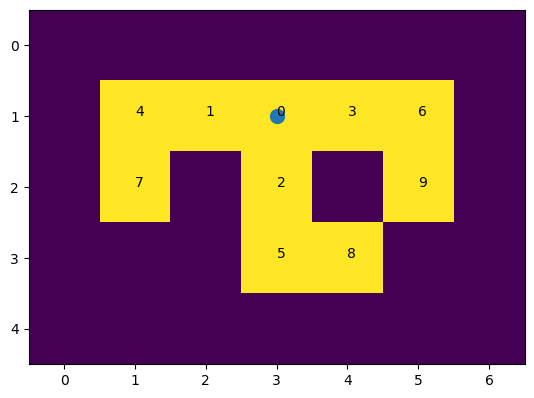

In [9]:
maze_text = gt.read_maze_text('mazes/maze_3way.txt')
graph = gt.maze_text_to_graph(maze_text)
came_from = gs.breadth_first_traverse(graph,(1,3))
plt.imshow(gt.maze_text_to_matrix(maze_text))
plt.scatter(y=1,x=3,s=100)
for i,node in enumerate(came_from.keys()):
    y,x = node
    plt.text(s=int(i),y=y,x=x)
plt.show()

I grafen over kan man se at de tre naboene til startnoden ble "besøkt" først (nummmer 0,1,2). Deretter ble alle nodene som er to steg unna startnoden besøkt (3,4 og 5), og til slutt ble nodene som er tre steg unna besøkt (6,7 og 8). Dette mønsteret, der man besøker alle noder innen en viss rekkevidde før man beveger seg lengre unna startnoen, er grunnen til at algoritmen kalles "bredde først".


Vi kan gjøre det samme med en større og mer kompleks graf, der vi starter i node (4,4):

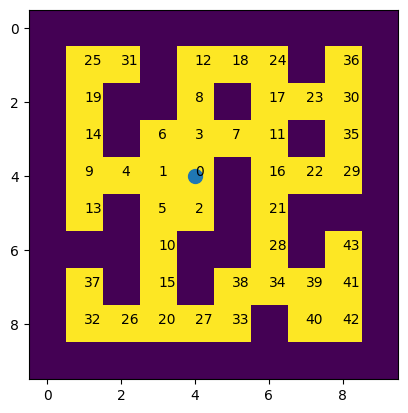

In [10]:
maze_text = gt.read_maze_text('mazes/maze_10x10.txt')
graph = gt.maze_text_to_graph(maze_text)
came_from = gs.breadth_first_traverse(graph,(4,4))
plt.imshow(gt.maze_text_to_matrix(maze_text))
plt.scatter(y=4,x=4,s=100)
for i,node in enumerate(came_from.keys()):
    y,x = node
    plt.text(s=int(i),y=y,x=x)
plt.show()

Legg merke til det samme "bredde-først"-mønsteret. 

Informasjonen in came_from forteller oss hvilke noder som måtte "oppdages" på veien fram til en gitt node. La oss for eksempel ta noden (2,7), som har nummer 22 i grafen over, og nøste oss bakover:

In [11]:
came_from[(2,7)]

(2, 6)

Node (2,7) ble altså "oppdaget" fra node (2,6). Og fra hvilken node ble (2,6) oppdaget?

In [12]:
came_from[(2,6)]

(3, 6)

Vi fortsetter og ser hvor langt vi kommer:

In [13]:
came_from[(3,6)]

(3, 5)

In [14]:
came_from[(3,5)]

(3, 4)

In [15]:
came_from[(3,4)]

(4, 4)

In [16]:
came_from[(4,4)]  

Vi får ikke noen output for came_from[(4,4)] siden dette er startnoden (vi kom ikke fra noen node før vi startet her). Hvis vi nå ser på denne "oppnøstinga" baklengs, og starter med startnoden, kan vi finne veien fra startnoden til noden vi begynte med:

(4,4) -> (3,4) -> (3,5) -> (3,6) -> (2,6) -> (2,7)

Dette er en av flere potensielle veier vi kunne ha gått mellom (4,4) og (2,7). Det spesielle med denne veien er at den er den _korteste_ mulige veien. Det viser seg at dette gjelder helt generelt: Når vi bruker bredde-først-søk og nøster oss tilbake til utgangspunktet, gjør vi det via den korteste mulige veien. Prøv gjerne selv med en annen tilfeldig node i grafen over. I tilfeller der det finnes mer enn en korteste vei, vil algoritmen gi en av dem. 

I innlevering 3 skal du selv implementere en funksjon ("path_backtrack") som finner korteste vei, gitt en startnode, en sluttnode og en came_from-dictionary fra tidligere traversering.  

Det å finne den korteste veien i en graf med mange mulige veier er veldig nyttig i mange sammenhenger. Når du bruker GPS-navigasjon på telefonen, gjør den noe lignende som det vi gjorde over (verden er representert som en graf), men med litt mer avanserte algoritmer. 

# Finne tilgjengelige noder  ("reachable nodes")
## Ikke-sammenhengende grafer
I grafene som vi har sett på over, er alle nodene bundet sammen i en enkelt struktur (en "sammenhengende" graf), slik at enhver node kan nås fra hvilken som helst annen node. Dette er ikke alltid tilfelle. I noen tilfeller kan man ha to eller flere "subgrafer" som ikke henger sammen. Kodesnutten under viser et eksempel på dette:

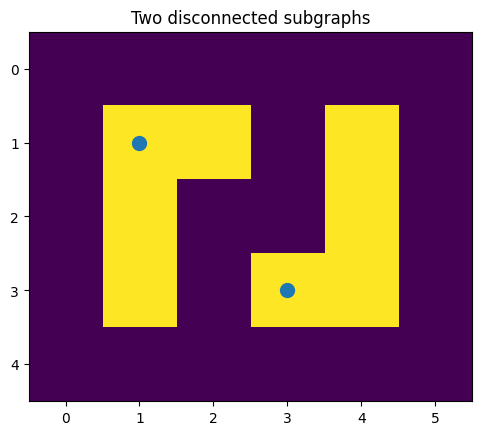

In [17]:
maze_text = gt.read_maze_text('mazes/maze_disconnected.txt')
graph = gt.maze_text_to_graph(maze_text)
plt.imshow(gt.maze_text_to_matrix(maze_text))
plt.scatter(y=(1,3),x=(1,3),s=100)
plt.title('Two disconnected subgraphs')
plt.show()

I tilfellet over kan vi se at man får to separate "ganger" i labyrinten, en til venstre og en til høyre. Nodene i den høyre delen kan ikke nås hvis man starter i den venstre delen. Hvis man for eksempel starter i node (1,1), kan man ikke nå node (3,3).

## Rettede grafer
Et annet tilfelle der man ikke kan nå alle nodene er i en såkalt "rettet" graf. I en slik graf er kantene mellom nodene "enveiskjørt". Denne type graf er ikke så lett å visualisere med et rutenett, så vi ser på et eksempel med en klassisk ellipser-og-piler-framstilling: 

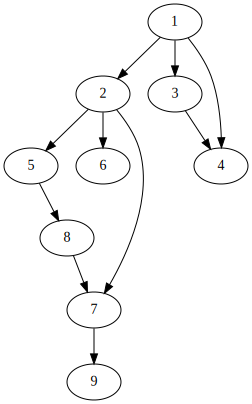

In [19]:
graph = {1:[2,3,4],2:[5,6,7],3:[4],4:[],5:[8],6:[],7:[9],8:[7],9:[]}
graph_dot = dict_to_dot(graph,directed=True)
graph_dot

Hvis man starter i node 1 i grafen over, kan man nå hvilken som helst av de andre nodene - men hvis man for eksempel starter i node 5 kan man kun nå node 5, 8, 7 og 9. 

## Metode for å finne tilgjengelige noder
Vi kan bruke bredde-først traversering for å finne ut hvilke noder som er tilgjengelige fra en gitt startnode. En slik traversering vil "bre seg ut" inntil den har nådd alle nodene som er tilgjengelige. Utilgjengelige noder vil aldri bli del av traverseringen, selv om de er del av grafen. 

I innleveringen skal dere lage en funksjon som returnerer et sett med alle nodene som er tilgjengelige. Kodesnutten under illustrerer hvordan denne funksjonen brukes på de to eksempel-grafene over.  

In [20]:
maze_graph = gt.maze_text_to_graph(gt.read_maze_text('mazes/maze_disconnected.txt'))
reachable_nodes_1_1 = gs.get_reachable_nodes(maze_graph,(1,1))
print(f'Nodes reachable from node (1,1): {reachable_nodes_1_1}')

Nodes reachable from node (1,1): {(3, 1), (1, 1), (1, 2), (2, 1)}


In [21]:
directed_graph = {1:[2,3,4],2:[5,6,7],3:[4],4:[],5:[8],6:[],7:[9],8:[7],9:[]}
reachable_nodes_1 = gs.get_reachable_nodes(directed_graph,1)
reachable_nodes_5 = gs.get_reachable_nodes(directed_graph,5)
print(f'Nodes reachable from node 1: {reachable_nodes_1}')
print(f'Nodes reachable from node 5: {reachable_nodes_5}')

Nodes reachable from node 1: {1, 2, 3, 4, 5, 6, 7, 8, 9}
Nodes reachable from node 5: {8, 9, 5, 7}


# Bredde-først søk
Med bredde-først traversering oppdager vi strukturen til grafen, og vi kan finne korteste vei fra startnoden til hvilken som helst annen node. La oss nå anta at vi ikke er interessert i alle nodene - vi er kun interessert i korteste vei fra startnoden til en enkelt sluttnode. Da kan vi gjøre en liten modifikasjon på koden vi brukte over - vi begynner med å traversere grafen på samme måte, men når vi har behandlet sluttnoden, stopper vi (såkalt "early stopping"). Dette har fordelen at vi slipper å bruke tid og ressurser på å besøke noder vi ikke er interesserte i. 

Vi kaller denne metoden bredde-først _søk_, for å skille den fra traversering, som vi gjorde over. 

    breadth_first_traverse(graph,start_node):
        let frontier equal a new queue
        let came_from equal a new dict
        
        enqueue start_node to frontier
        set came_from for start_node to None
        
        while frontier is not empty:
            dequeue a node from frontier and let it equal current_node
            if current_node is the end_node:
                break while loop
            for every neighbor of current_node in graph:
                if the neighbor has not been discovered (not yet present in came_from):
                    enqueue the neighbor to frontier
                    update came_from: set neighbor as key and current_node as value
        
        if end_node was found:
            let shortest_path equal a new list
            construct the shortest path from start_node to end_node, and save it to shortest_path
        else:
            set shortest_path to None
        
        return came_from and shortest_path

Koden over returnerer came_from, som inneholder oversikten over hvilke noder som har blitt oppdaget, og hvilke noder de ble oppdaget fra. Dette er ikke egentlig nødvendig for funksjonaliteten, men det gjør det mulig å illustrere forskjellen mellom traversering og søk (se under). 

I pseudokoden stopper vi først når end_node "poppes" fra køen. Egentlig kunne vi ha stoppet allerede første gang noden ble oppdaget (da den ble lagt inn i køen). Likevel bruker vi koden over, fordi denne koden da blir svært lik koden som brukes for _vektede_ grafer (som kommer i innlevering 4).

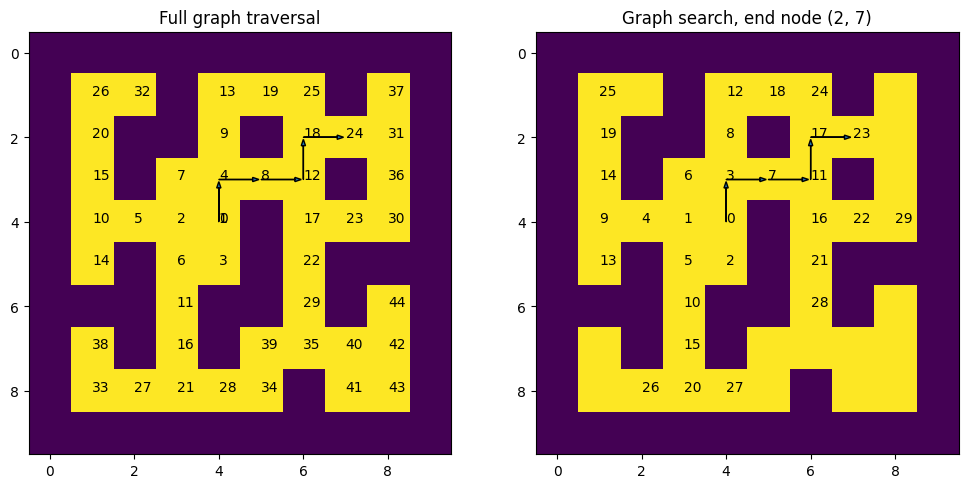

In [22]:
# Load maze, define start and end
maze_text = gt.read_maze_text('mazes/maze_10x10.txt')
graph = gt.maze_text_to_graph(maze_text)
grid = gt.maze_text_to_matrix(maze_text)
start_node = (4,4)
end_node = (2,7)

# Traverse
came_from_bft = gs.breadth_first_traverse(graph,start_node) 
path_bft = gs.path_backtrack(start_node,end_node,came_from)
visited_bft = [node for node in came_from_bft]
visited_bft.insert(0,start_node)

# Search
visited_bfs,path_bfs = gs.breadth_first_search(graph,start_node,end_node)

# Plot and compare
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(12,8))
plt.sca(ax[0])
plt.imshow(grid)
gt.plot_path(path_bft)
gt.plot_visited(visited_bft)
plt.title('Full graph traversal')

plt.sca(ax[1])
plt.imshow(grid)
gt.plot_path(path_bfs)
gt.plot_visited(visited_bfs)
plt.title(f'Graph search, end node {end_node}')

plt.show()

I rutenettene over kan vi se hvordan trverserings- og søkealgoritmen begge finner samme korteste vei, men at søkealgoritmen kun besøker rundt halvparten av nodene. 

# Demonstrasjon med søk i større graf (labyrint)
Helt til slutt kan vi teste søkealgoritmen vår på en stor labyrint (100x100 piksler). Vi "fargelegger" labyrinten slik:
- Mørk blå: Vegger
- Lys blå: Noder som ikke har blitt besøkt
- Grønn: Noder som har blitt besøkt
- Gul: Korteste vei fra start til slutt

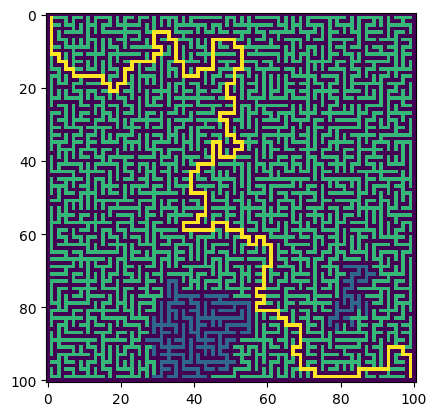

In [23]:
maze_text = gt.read_maze_text('mazes/maze_100x100.txt')
start_node = (1,1)
end_node = (99,99)
graph = gt.maze_text_to_graph(maze_text)
grid = gt.maze_text_to_matrix(maze_text)

came_from,path = gs.breadth_first_search(graph,start_node,end_node)
for y,x in came_from:
    grid[y,x] = 2
for y,x in path:
    grid[y,x] = 3
plt.imshow(grid)
plt.show()


Vi kan se at nesten hele labyrinten er grønn, dvs. at nesten alle nodene har blitt oppdaget. Den finnes to mindre blå områder med noder som ikke er oppdaget; disse er noder som har så stor avstand til startnoden at algoritmen ikke "rakk" å utforske dem før den fant sluttnoden.

# Oppgaver
1. Implementer bredde-først traversering
2. Implementer "backtracking" basert på came_from for å konstruere korteste vei fra start- til slutt-node
3. Implementer en funksjon som returnerer hvilke noder som er innen rekkevidde fra en gitt startnode
4. Implementer bredde-først søk, som stopper traversering av grafen når en sluttnode er funnet. 

Detaljene for hver funksjon er oppgitt i dokumentasjonen som dere finner i fila graph_search.py .